# I. Giới thiệu về mô hình

Từ kết quả của quá trình gom cụm, ta đã phân khách hàng ra thành 3 cụm với những đặc tính riêng biệt. Bây giờ, ta sẽ xây dựng một mô hình phân lớp với biến mục tiêu là Cụm mà khách hàng thuộc về.

Từ đó, khi có thêm thông tin về khách hàng mới, ta có thể dự đoán khách hàng thuộc về cụm nào để có các chiến lược kinh doanh phù hợp

# II. Mô hình hoá

## 1. Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt


## 2. Đọc dữ liệu từ file đã xử lý

In [4]:
df = pd.read_csv('./data/marketing_campaign_modeling.csv')
df.head()

,Education,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Response,Age,Age Group,Kids,Total Purchases,Spent,Family Size,Marital_Status_In Relationship,Marital_Status_Single,Cluster
0,-0.792105,0.288947,1.529793,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,2.386338,1.016868,0.474103,-1.264308,1.319340,1.680176,-1.758810,-1.347635,1.347635,2
1,-0.792105,-0.262003,-1.191143,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,-0.419052,1.273264,1.639042,1.395139,-1.155857,-0.962202,0.445618,-1.347635,1.347635,1
2,-0.792105,0.918423,-0.206659,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,-0.419052,0.333146,0.474103,-1.264308,0.798246,0.282541,-0.656596,0.742041,-0.742041,0
3,-0.792105,-1.182183,-1.062517,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,-0.419052,-1.290693,-0.690836,0.065416,-0.895310,-0.918994,0.445618,0.742041,-0.742041,1
4,1.590069,0.296187,-0.953679,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,-0.419052,-1.034298,-0.690836,0.065416,0.537699,-0.305762,0.445618,0.742041,-0.742041,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Education                       2236 non-null   float64
 1   Income                          2236 non-null   float64
 2   Dt_Customer                     2236 non-null   float64
 3   Recency                         2236 non-null   float64
 4   MntWines                        2236 non-null   float64
 5   MntFruits                       2236 non-null   float64
 6   MntMeatProducts                 2236 non-null   float64
 7   MntFishProducts                 2236 non-null   float64
 8   MntSweetProducts                2236 non-null   float64
 9   MntGoldProds                    2236 non-null   float64
 10  NumDealsPurchases               2236 non-null   float64
 11  NumWebPurchases                 2236 non-null   float64
 12  NumCatalogPurchases             22

Dữ liệu đã được xử lý phù hợp với việc mô hình hoá

## 3. Lựa chọn đặc trưng

<Axes: >

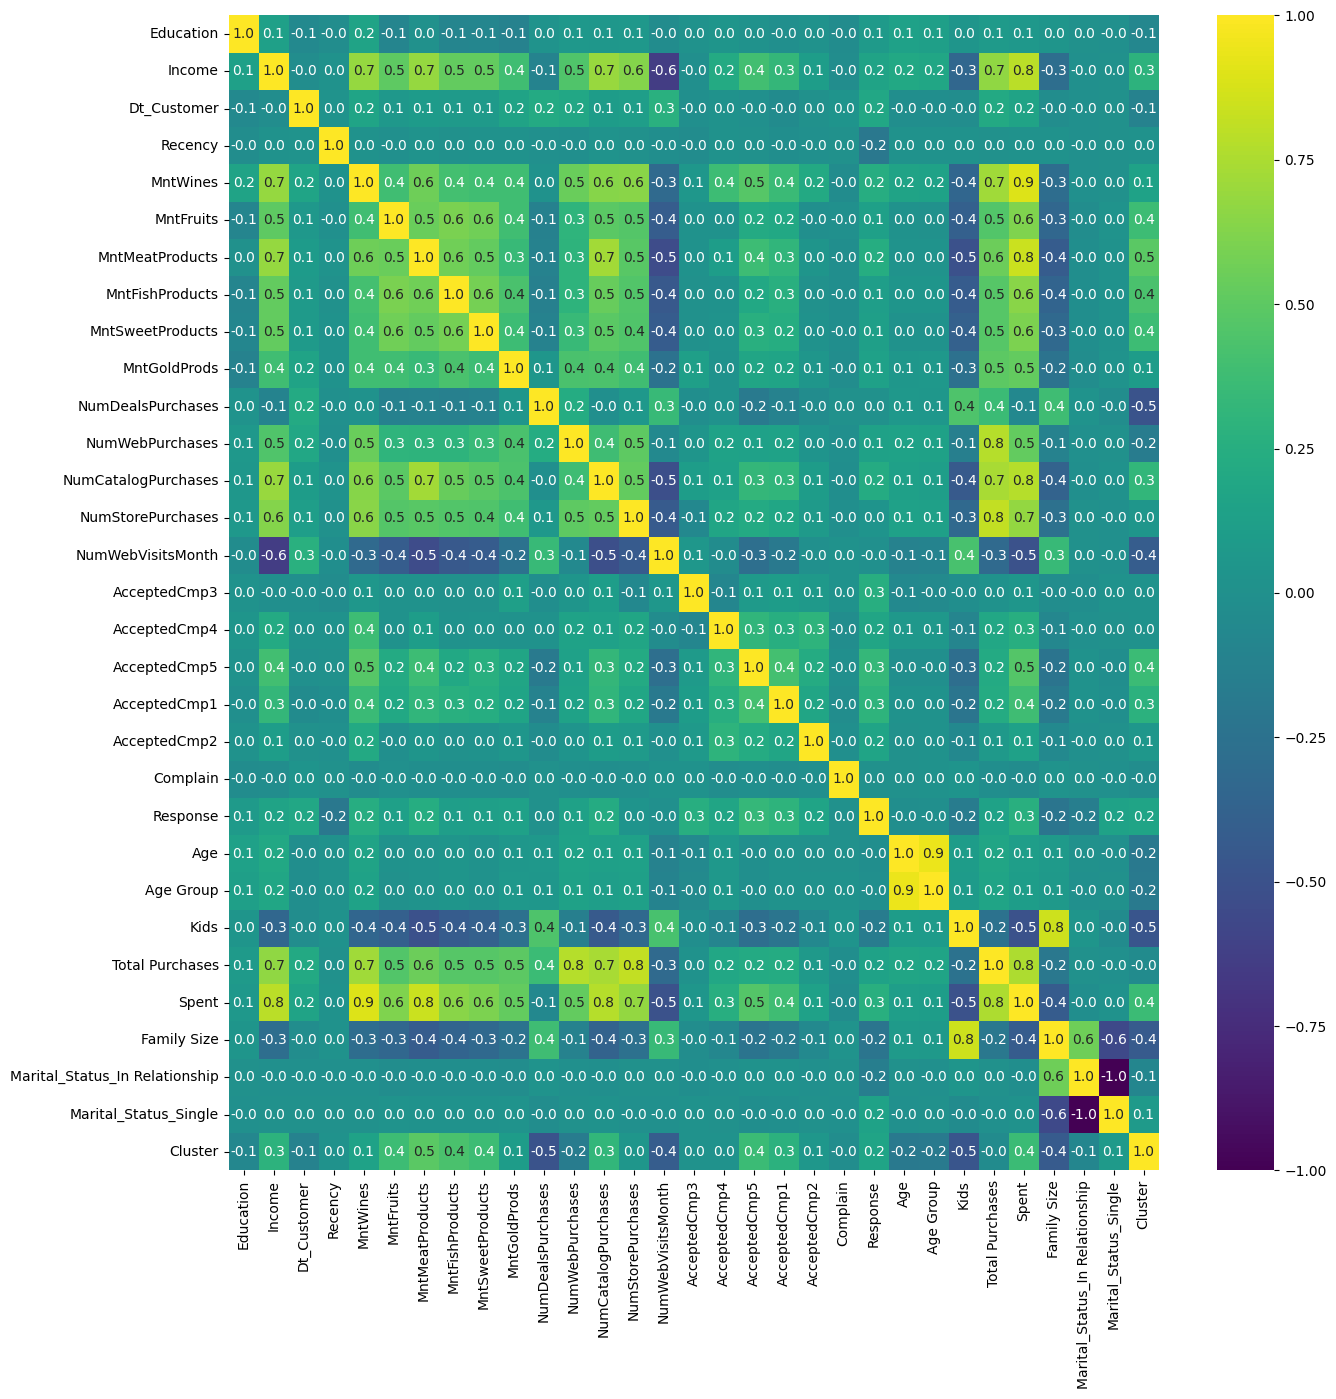

In [6]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap='viridis')

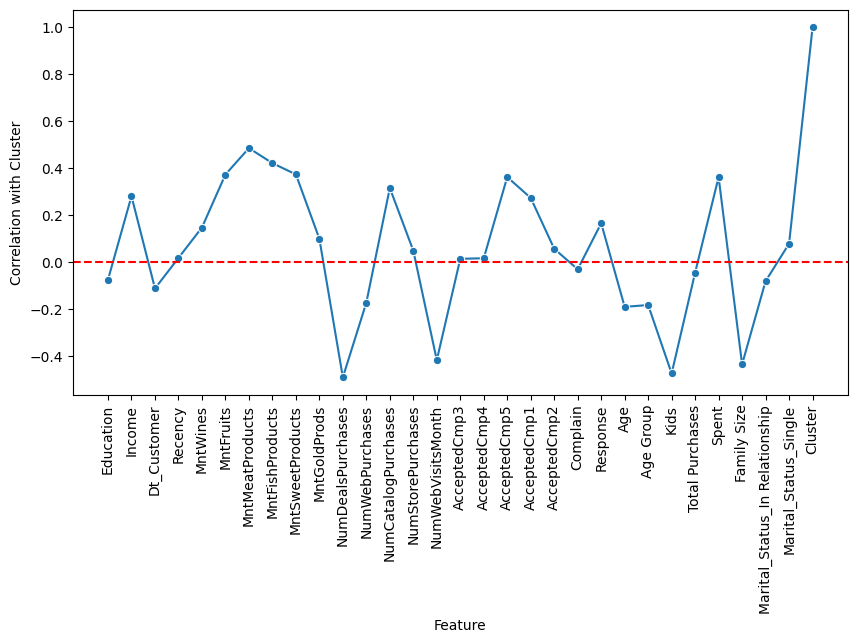

In [7]:
plt.figure(figsize=(10, 5))
sns.lineplot(df.corr()['Cluster'], marker='o');
plt.xlabel('Feature')
plt.ylabel('Correlation with Cluster')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xticks(rotation=90);

Ta sẽ bỏ đi các features có ít độ tương quan với biến mục tiêu, bao gồm:

- Recency

- AcceptedCmp3

- AcceptedCmp4

- Complain

In [8]:
df.drop(['Recency','AcceptedCmp3', 'AcceptedCmp4', 'Complain'], axis=1, inplace=True)
df.head()

,Education,Income,Dt_Customer,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Response,Age,Age Group,Kids,Total Purchases,Spent,Family Size,Marital_Status_In Relationship,Marital_Status_Single,Cluster
0,-0.792105,0.288947,1.529793,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,0.348738,...,2.386338,1.016868,0.474103,-1.264308,1.319340,1.680176,-1.758810,-1.347635,1.347635,2
1,-0.792105,-0.262003,-1.191143,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,-0.168700,...,-0.419052,1.273264,1.639042,1.395139,-1.155857,-0.962202,0.445618,-1.347635,1.347635,1
2,-0.792105,0.918423,-0.206659,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,-0.686137,...,-0.419052,0.333146,0.474103,-1.264308,0.798246,0.282541,-0.656596,0.742041,-0.742041,0
3,-0.792105,-1.182183,-1.062517,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,-0.168700,...,-0.419052,-1.290693,-0.690836,0.065416,-0.895310,-0.918994,0.445618,0.742041,-0.742041,1
4,1.590069,0.296187,-0.953679,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,1.383614,...,-0.419052,-1.034298,-0.690836,0.065416,0.537699,-0.305762,0.445618,0.742041,-0.742041,0


## 4. Huấn luyện và đánh giá

**Chia dữ liệu train và test**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Cluster', axis=1), df['Cluster'], test_size=0.3, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1565, 26)
X_test shape: (671, 26)
y_train shape: (1565,)
y_test shape: (671,)


In [10]:
def evaluate_model(model, X_train, y_train, cv):
    scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print(scores)
    print(f'Mean accuracy: {scores.mean():.2f}')

Sử dụng kfold với k = 5

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

**Mô hình Decision Tree**

In [12]:
dtree = DecisionTreeClassifier(random_state=42)
evaluate_model(dtree, X_train, y_train, kf)

[0.90415335 0.9201278  0.89776358 0.90734824 0.90734824]
Mean accuracy: 0.91


*Nhận xét*

- Với mô hình đơn giản như `Decision Tree` nhưng độ chính xác trên tập Train tương đối cao

- Tuy nhiên, có vài sự chênh lệch giữa các lần huấn luyện cho thấy vấn đề Overfitting (thường gặp ở mô hình Decision Tree)

**Mô hình Random Forest**

Vì đây thuộc về bài toán phân lớp nên ta sẽ sử dụng một mô hình tiêu biểu là `Decision Tree`, tuy nhiên để nâng cao khả năng tổng quát hoá thì ta có thể dùng `Random Forest`

In [13]:
forest = RandomForestClassifier(random_state=42)
evaluate_model(forest, X_train, y_train, kf)

[0.93929712 0.95527157 0.95527157 0.9456869  0.94888179]
Mean accuracy: 0.95


*Nhận xét*

- Accuracy cao hơn Desicion Tree khá nhiều

- Chênh lệch giữa các lần huấn luyện giảm xuống cho thấy một phần khắc phụ được vấn đề Overfitting như mong muốn

**Lựa chọn mô hình**

Mô hình mà ta sẽ lựa chọn là `Random Forest`

**Hyper-parameter tunning**

In [14]:
from sklearn.model_selection import GridSearchCV


Bây giờ ta sẽ tìm ra các siêu tham số phù hợp cho mô hình `Random Forest`

In [15]:
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), grid_params, cv=kf, n_jobs=-1)



In [16]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Kiểm tra trên tập Train

In [18]:
print(f'Accuracy score: {np.round(grid_search.score(X_train, y_train), 4)}')

Accuracy score: 0.9987


Kiểm tra trên tập Test

In [19]:
print(f'Accuracy score: {np.round(grid_search.score(X_test, y_test), 4)}')

Accuracy score: 0.9642


**Nhận xét**

- Hiệu suất của mô hình tương đối cao

- Độ chính xác trên tập Train rất cao nhưng ở tập test thì thấp hơn một chút cho thấy vấn đề Overfitting. Tuy nhiên, performance trên tập Test vẫn rất cao

- Với mô hình này, ta có thể dùng để phân loại một khách hàng mới vào nhóm thích hợp với độ chính xác cao.

- Để cải thiện được nhiều hơn nữa, ta có thể cân nhắc việc bổ sung thêm các features quan trọng mới